# Семинар 5

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (15, 7)

## Линейная классификация

### Постановка задачи классификации

Пусть задана обучающая выборка $X = \left\{ \left( x_i, y_i \right) \right\}_{i=1}^l, x_i \in \mathbb{X}, y_i \in \mathbb{Y},$ — $l$ пар объект-ответ, где
$\mathbb{X}$ — пространство объектов,
$\mathbb{Y}$ — пространство ответов.


### Логистическая регрессия

Рассмотрим в качестве верхней оценки пороговой функции потерь логистическую функцию:

$$\tilde{L}(M) = \log (1 + \exp(-M)).$$

Таким образом, необходимо решить следующую оптимизационную задачу:
$$\frac{1}{l} \sum_{i=1}^l \tilde{L} (M_i) = \frac{1}{l} \sum_{i=1}^l \log (1 + \exp (-y_i \langle w, x_i \rangle)) \to \min_w$$

Получившийся метод обучения называется **логистической регрессией**.

Одно из полезных свойств логистической регрессии, которое будет изучено нами несколько позднее, — тот факт, что она позволяет предсказывать помимо метки класса ещё и вероятность принадлежности каждому из них, что может быть полезным в некоторых задачах.

**Пример**: Вы работаете в банке и хотите выдавать кредиты только тем клиентам, которые вернут его с вероятностью не меньше 0.9.

Попробуем сконструировать функцию потерь из других соображений.
Если алгоритм $b(x) \in [0, 1]$ действительно выдает вероятности, то
они должны согласовываться с выборкой.
С точки зрения алгоритма вероятность того, что в выборке встретится объект $x_i$ с классом $y_i$,
равна $b(x_i)^{[y_i = +1]} (1 - b(x_i))^{[y_i = -1]}$.

Исходя из этого, можно записать правдоподобие выборки (т.е. вероятность получить такую выборку
с точки зрения алгоритма):
$$
    Q(a, X)
    =
    \prod_{i = 1}^{\ell}
        b(x_i)^{[y_i = +1]} (1 - b(x_i))^{[y_i = -1]}.
$$
Данное правдоподобие можно использовать как функционал для обучения алгоритма --
с той лишь оговоркой, что удобнее оптимизировать его логарифм:
$$
    -\sum_{i = 1}^{\ell} \left(
        [y_i = +1] \log b(x_i)
        +
        [y_i = -1] \log (1 - b(x_i))
    \right)
    \to
    \min
$$
Данная функция потерь называется логарифмической (log-loss).

Мы хотим предсказывать вероятности, то есть, чтобы наш алгоритм предсказывал числа в интервале [0, 1]. Этого легко достичь, если положить $b(x) = \sigma(\langle w, x \rangle)$,
где в качестве $\sigma$ может выступать любая монотонно неубывающая функция
с областью значений $[0, 1]$.
Мы будем использовать сигмоидную функцию: $\sigma(z) = \frac{1}{1 + \exp(-z)}$.
Таким образом, чем больше скалярное произведение $\langle w, x \rangle$,
тем больше будет предсказанная вероятность.

Подставим трансформированный ответ линейной модели в логарифмическую функцию потерь:
\begin{align*}
    -\sum_{i = 1}^{\ell} &\left(
        [y_i = +1]
        \log \frac{1}{1 + \exp(-\langle w, x_i \rangle)}
        +
        [y_i = -1]
        \log \frac{\exp(-\langle w, x_i \rangle)}{1 + \exp(-\langle w, x_i \rangle)}
    \right)
    =\\
    &=
    -\sum_{i = 1}^{\ell} \left(
        [y_i = +1]
        \log \frac{1}{1 + \exp(-\langle w, x_i \rangle)}
        +
        [y_i = -1]
        \log \frac{1}{1 + \exp(\langle w, x_i \rangle)}
    \right)
    =\\
    &=
    \sum_{i = 1}^{\ell} \left(
        [y_i = +1]
        \log (1 + \exp(-\langle w, x_i \rangle))
        +
        [y_i = -1]
        \log (1 + \exp(\langle w, x_i \rangle))
    \right)
    =\\
    &=
    \sum_{i = 1}^{\ell}
        \log \left(
            1 + \exp(-y_i \langle w, x_i \rangle)
        \right).
\end{align*}

Полученная функция в точности представляет собой логистические потери,
упомянутые в начале.
Линейная модель классификации, настроенная путём минимизации данного функционала,
называется логистической регрессией.
Как видно из приведенных рассуждений, она оптимизирует
правдоподобие выборки и дает корректные оценки вероятности принадлежности к положительному классу.


### Пример обучения логистической регрессии
#### Определение спама по тексту электронного письма

Попробуем при помощи моделей линейной классификации построить алгоритм, отделяющий спам от нормальной почты. Для экспериментов воспользуемся небольшим набором данных с [UCI](https://archive.ics.uci.edu/ml/datasets.html). Объекты в датасете соответствуют письмам, которые описаны признаками на основе текста письма, спам — положительный пример для классификации, хорошее письмо — отрицательный пример.


In [5]:
spam_data = pd.read_csv('spam_data.csv')
spam_data.columns

Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',


In [6]:
X, y = spam_data.iloc[:, :-1].values, spam_data.iloc[:, -1].values
X.shape, y.shape

((4601, 57), (4601,))

In [10]:
spam_data['spam'].value_counts()

0    2788
1    1813
Name: spam, dtype: int64

### Обучение логистической регрессии

Разделим выборку на обучающую и тестовую в отношении 80/20 и обучим логистическую регрессию при помощи объекта [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [7]:
from sklearn.linear_model import LogisticRegression

X_train = X[:int(len(X) * 0.8)]
y_train = y[:int(len(X) * 0.8)]
X_test = X[int(len(X) * 0.8):]
y_test = y[int(len(X) * 0.8):]

In [8]:
??LogisticRegression

In [11]:
lr = LogisticRegression(max_iter=3000, solver='lbfgs', random_state=13)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
def pred_with_th(X, model, th=0.5):
  th = min(max(0, th),1)
  probs = model.predict_proba(X)
  labels = np.zeros(X.shape[0])
  labels = probs > th
  return labels 

Вычислим долю правильных ответов при помощи соответствующей функции из модуля [sklearn.metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [13]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, lr.predict(X_train)))
print(accuracy_score(y_test, lr.predict(X_test)))

0.93125
0.7958740499457112


В чем проблема?

In [16]:
X_train = X[:int(len(X) * 0.8)]
y_train = y[:int(len(X) * 0.8)]
X_test = X[int(len(X) * 0.8):]
y_test = y[int(len(X) * 0.8):]

In [17]:
y_train.mean(), y_test.mean()

(0.24239130434782608, 1.0)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
y_train.mean(), y_test.mean()

(0.39565217391304347, 0.38762214983713356)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=13)
y_train.mean(), y_test.mean()

(0.39402173913043476, 0.3941368078175896)

In [19]:
# training
lr = LogisticRegression(max_iter=3000, solver='lbfgs')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
print(accuracy_score(y_train, lr.predict(X_train)))
print(accuracy_score(y_test, lr.predict(X_test)))

0.9375
0.9120521172638436


In [24]:
lr.predict_proba(X_train).sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

Теперь будем смотреть на AUC-ROC:

In [21]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1]))
print(roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))

0.9792709138704191
0.959082516267267


Давайте попробуем сделать лучше. У нашего алгоритма есть разные гиперпараметры: способ регуляризации, коэффициент регуляризации. Запустим поиск по сетке гиперпараметров, алгоритм переберет все возможные комбинации, посчитает метрику для каждого набора и выдаст лучший набор.

In [28]:
np.logspace(-5, 1, 5)

array([1.00000000e-05, 3.16227766e-04, 1.00000000e-02, 3.16227766e-01,
       1.00000000e+01])

In [29]:
np.linspace(10**(-5), 10, 5)

array([1.0000000e-05, 2.5000075e+00, 5.0000050e+00, 7.5000025e+00,
       1.0000000e+01])

То, какая метрика будет использоваться, определяется параметром `'scoring'`.

In [30]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [31]:
from sklearn.model_selection import GridSearchCV

In [ ]:
GridSearchCV()

In [32]:
from sklearn.model_selection import GridSearchCV
grid_searcher = GridSearchCV(
    LogisticRegression(max_iter=3000, solver='liblinear', random_state=13),
    param_grid={
        'C': np.logspace(-5, 1, 6),
        'penalty': ['l1', 'l2']
    },
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=5
)

In [34]:
np.logspace(-5, 1, 6).shape

(6,)

Параметр `cv=5` говорит, что во время поиска оптимальных параметров будет использоваться кросс-валидация с 5 фолдами. Давайте вспомним, что это такое: 

![alt text](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

*Source: https://scikit-learn.org/stable/modules/cross_validation.html*

В нашем случае, выборка будет разделена на 5 частей, и на каждой из 5 итераций часть данных будет становиться тестовой выборкой, а другая часть - обучающей. Посчитав метрики на каждой итерации, мы сможем усреднить их в конце и получить достаточно точную оценку качества нашего алгоритма.

In [33]:
%%time

grid_searcher.fit(X_train, y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.2s


CPU times: user 225 ms, sys: 48.2 ms, total: 274 ms
Wall time: 2.62 s


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=3000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=13, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 1.58489319e-04, 2.51188643e-03, 3.98107171e-02,
       6.30957344e-01, 1.00000000e+01]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=5)

In [36]:
best_model = grid_searcher.best_estimator_

Посмотрим на результаты лучшей модели.

In [37]:
print(roc_auc_score(y_train, grid_searcher.predict_proba(X_train)[:, 1]))
print(roc_auc_score(y_test, grid_searcher.predict_proba(X_test)[:, 1]))

0.9797957321787536
0.9601686463856551


Полные результаты поиска гиперпараметров:

In [38]:
pd.DataFrame(grid_searcher.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009100,0.001268,0.003039,0.000044,1e-05,l1,"{'C': 1e-05, 'penalty': 'l1'}",0.747449,0.766457,0.788754,0.773601,0.730134,0.761279,0.020469,12
1,0.016491,0.002699,0.004468,0.003114,1e-05,l2,"{'C': 1e-05, 'penalty': 'l2'}",0.853920,0.845400,0.847766,0.855969,0.819283,0.844467,0.013173,10
2,0.011038,0.000997,0.003154,0.000277,0.000158489,l1,"{'C': 0.00015848931924611142, 'penalty': 'l1'}",0.807623,0.800166,0.822251,0.810109,0.783354,0.804701,0.012822,11
3,0.024759,0.003065,0.002863,0.000131,0.000158489,l2,"{'C': 0.00015848931924611142, 'penalty': 'l2'}",0.910809,0.910020,0.920782,0.923968,0.894580,0.912032,0.010287,8
4,0.015270,0.005803,0.002957,0.000080,0.00251189,l1,"{'C': 0.0025118864315095794, 'penalty': 'l1'}",0.895183,0.879488,0.895775,0.898048,0.873110,0.888321,0.010066,9
5,0.050225,0.021429,0.003762,0.001585,0.00251189,l2,"{'C': 0.0025118864315095794, 'penalty': 'l2'}",0.951446,0.956827,0.954538,0.954523,0.952165,0.953900,0.001918,7
6,0.019940,0.002419,0.003180,0.000326,0.0398107,l1,"{'C': 0.03981071705534969, 'penalty': 'l1'}",0.964288,0.969530,0.960275,0.962927,0.970690,0.965542,0.003964,6
7,0.058486,0.013591,0.003087,0.000152,0.0398107,l2,"{'C': 0.03981071705534969, 'penalty': 'l2'}",0.971641,0.975043,0.962935,0.964999,0.973744,0.969672,0.004827,5
8,0.021890,0.002675,0.002899,0.000132,0.630957,l1,"{'C': 0.630957344480193, 'penalty': 'l1'}",0.975414,0.979419,0.967373,0.971965,0.982132,0.975261,0.005246,1
9,0.093863,0.038499,0.003230,0.000209,0.630957,l2,"{'C': 0.630957344480193, 'penalty': 'l2'}",0.975978,0.978707,0.967040,0.970311,0.980980,0.974603,0.005197,3


Лучшие гиперпараметры:

In [39]:
grid_searcher.best_params_

{'C': 0.630957344480193, 'penalty': 'l1'}

Лучший скор модели на кросс-валидации:

In [40]:
grid_searcher.best_score_

0.9752605535797123

Мы также можем выделить лучшую модель:

In [41]:
lr = grid_searcher.best_estimator_

LogisticRegression(C=0.630957344480193, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=3000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=13, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Оценку модели на кросс-валидации мы можем получить и без перебора гиперпараметров:

In [42]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(lr, X_train, y_train, scoring='roc_auc', cv=5)
print(cv_score)
print(cv_score.mean())

[0.97541364 0.97941859 0.96737282 0.97196536 0.98213236]
0.9752605535797123


Вместо перебора по сетке можно перебирать гиперпараметры, сгенерированные из заданного распределения.

In [60]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
#lr = LogisticRegression(max_iter=3000, solver='liblinear', random_state=13)
lr = SVC(C=C, kernel='rbf')
distributions = dict(C=uniform(loc=0.0001, scale=10))
clf = RandomizedSearchCV(lr, distributions, n_iter=50, cv=5, verbose=5, scoring='roc_auc', random_state=13, n_jobs=-1)

In [61]:
%%time
clf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [51]:
clf.best_score_

0.9753687954229164

In [52]:
print(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

0.9802837482603989
0.9596008965510431


Для некоторых моделей из `sklearn` можно сразу применить кросс-валидацию:

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(max_iter=3000, solver='lbfgs', cv=5, random_state=13)
lr.fit(X_train, y_train)

In [ ]:
lr.C_

In [ ]:
print(roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1]))
print(roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))

# SVM

Рассмотрим теперь другой подход к построению функции потерь,
основанный на максимизации зазора между классами.
Будем рассматривать линейные классификаторы вида
$$
    a(x) = sign (\langle w, x \rangle + b), \qquad w \in R^d, b \in R.
$$

### Разделимый случай
Будем считать, что существуют такие параметры $w_*$ и $b_*$,
что соответствующий им классификатор $a(x)$ не допускает ни одной ошибки
на обучающей выборке.
В этом случае говорят, что выборка __линейно разделима__.

Пусть задан некоторый классификатор $a(x) = sign (\langle w, x \rangle + b)$.
Заметим, что если одновременно умножить параметры $w$ и $b$
на одну и ту же положительную константу,
то классификатор не изменится.
Распорядимся этой свободой выбора и отнормируем параметры так, что

\begin{equation}
\label{eq:svmNormCond}
    \min_{x \in X} | \langle w, x \rangle + b| = 1.
\end{equation}

Можно показать, что расстояние от произвольной точки $x_0 \in R^d$ до гиперплоскости,
определяемой данным классификатором, равно

$$
    \rho(x_0, a)
    =
    \frac{
        |\langle w, x \rangle + b|
    }{
        \|w\|
    }.
$$

Тогда расстояние от гиперплоскости до ближайшего объекта обучающей выборки равно

$$
    \min_{x \in X}
    \frac{
        |\langle w, x \rangle + b|
    }{
        \|w\|
    }
    =
    \frac{1}{\|w\|} \min_{x \in X} |\langle w, x \rangle + b|
    =
    \frac{1}{\|w\|}.
$$

Данная величина также называется __отступом (margin)__.

Таким образом, если классификатор без ошибок разделяет обучающую выборку,
то ширина его разделяющей полосы равна $\frac{2}{\|w\|}$.
Известно, что максимизация ширины разделяющей полосы приводит
к повышению обобщающей способности классификатора.
Вспомним также, что на повышение обобщающей способности направлена и регуляризация,
которая штрафует большую норму весов -- а чем больше норма весов,
тем меньше ширина разделяющей полосы.

Итак, требуется построить классификатор, идеально разделяющий обучающую выборку,
и при этом имеющий максимальный отступ.
Запишем соответствующую оптимизационную задачу,
которая и будет определять метод опорных векторов для линейно разделимой выборки (hard margin support vector machine):
\begin{equation}
\label{eq:svmSep}
    \left\{
        \begin{aligned}
            & \frac{1}{2} \|w\|^2 \to \min_{w, b} \\
            & y_i \left(
                \langle w, x_i \rangle + b
            \right) \geq 1, \quad i = 1, \dots, \ell.
        \end{aligned}
    \right.
\end{equation}


### Неразделимый случай
Рассмотрим теперь общий случай, когда выборку
невозможно идеально разделить гиперплоскостью.
Это означает, что какие бы $w$ и $b$ мы не взяли,
хотя бы одно из ограничений в предыдущей задаче будет нарушено:

$$
    \exists x_i \in X:\
    y_i \left(
        \langle w, x_i \rangle + b
    \right) < 1.
$$

Сделаем эти ограничения "мягкими", введя штраф $\xi_i \geq 0$ за их нарушение:

$$
    y_i \left(
        \langle w, x_i \rangle + b
    \right) \geq 1 - \xi_i, \quad i = 1, \dots, \ell.
$$

Отметим, что если отступ объекта лежит между нулем и
единицей ($0 \leq y_i \left( \langle w, x_i \rangle + b \right) < 1$),
то объект верно классифицируется, но имеет ненулевой штраф $\xi > 0$.
Таким образом, мы штрафуем объекты за попадание внутрь разделяющей полосы.

Величина $\frac{1}{\|w\|}$ в данном случае называется мягким отступом (soft margin).
С одной стороны, мы хотим максимизировать отступ, с другой -- минимизировать
штраф за неидеальное разделение выборки $\sum_{i = 1}^{\ell} \xi_i$.
Эти две задачи противоречат друг другу: как правило, излишняя подгонка под
выборку приводит к маленькому отступу, и наоборот -- максимизация отступа
приводит к большой ошибке на обучении.
В качестве компромисса будем минимизировать взвешенную сумму двух указанных величин.
Приходим к оптимизационной задаче,
соответствующей методу опорных векторов для линейно неразделимой выборки (soft margin support vector machine)
\begin{equation}
\label{eq:svmUnsep}
    \left\{
        \begin{aligned}
            & \frac{1}{2} \|w\|^2 + C \sum_{i = 1}^{\ell} \xi_i \to \min_{w, b, \xi} \\
            & y_i \left(
                \langle w, x_i \rangle + b
            \right) \geq 1 - \xi_i, \quad i = 1, \dots, \ell, \\
            & \xi_i \geq 0, \quad i = 1, \dots, \ell.
        \end{aligned}
    \right.
\end{equation}
Чем больше здесь параметр $C$, тем сильнее мы будем настраиваться на обучающую выборку.

Исследуем зависимость положения разделяющей гиперплоскости в методе опорных векторов в зависимости от значения гиперпараметра $C$.

Сгенерируем двумерную искуственную выборку из двух различных нормальных распределений:

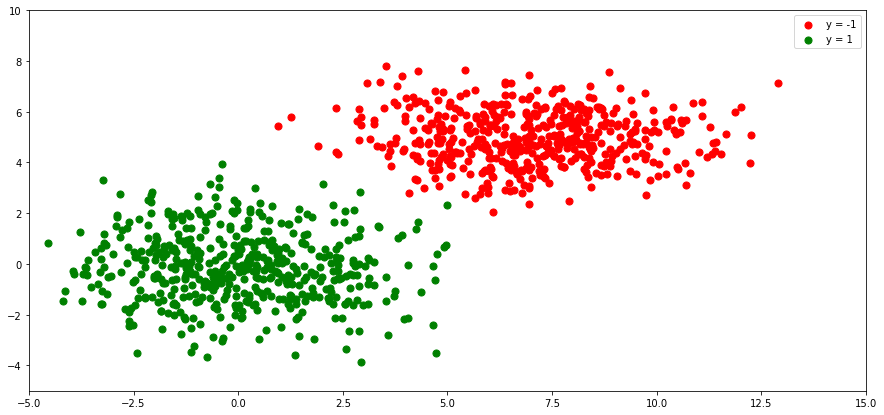

In [53]:
class_size=500

mean0 = [7, 5]
cov0 = [[4, 0], [0, 1]]  # diagonal covariance
mean1 = [0, 0]
cov1 = [[4, 0], [0, 2]]
data0 = np.random.multivariate_normal(mean0, cov0, class_size)
data1 = np.random.multivariate_normal(mean1, cov1, class_size)
data = np.vstack((data0, data1))
y = np.hstack((-np.ones(class_size), np.ones(class_size)))

plt.scatter(data0[:, 0], data0[:, 1], c='red', s=50)
plt.scatter(data1[:, 0], data1[:, 1], c='green', s=50)
plt.legend(['y = -1', 'y = 1'])
axes = plt.gca()
axes.set_xlim([-5,15])
axes.set_ylim([-5,10])
plt.show()

In [55]:
from sklearn.svm import SVC

SVM_classifier = SVC(C=0.01, kernel='linear') # changing C here
SVM_classifier.fit(data, y)

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

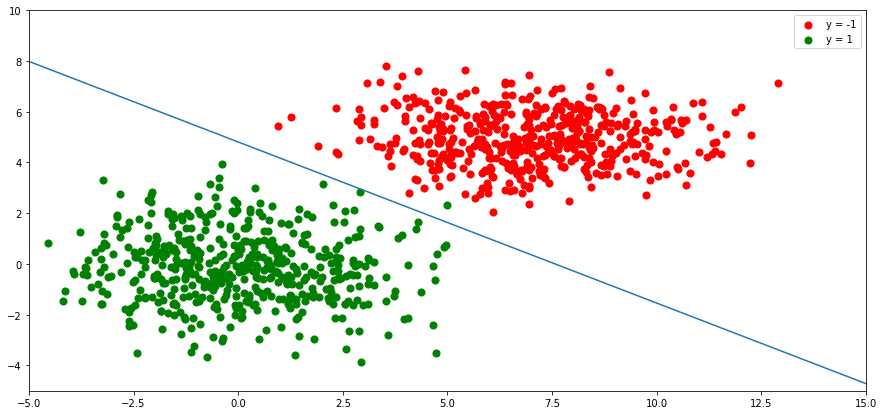

In [56]:
w_1 = SVM_classifier.coef_[0][0]
w_2 = SVM_classifier.coef_[0][1]
w_0 = SVM_classifier.intercept_[0]

plt.scatter(data0[:, 0], data0[:, 1], c='red', s=50)
plt.scatter(data1[:, 0], data1[:, 1], c='green', s=50)
plt.legend(['y = -1', 'y = 1'])
x_arr = np.linspace(-10, 15, 3000)
plt.plot(x_arr, -(w_0 + w_1 * x_arr) / w_2)
axes = plt.gca()
axes.set_xlim([-5,15])
axes.set_ylim([-5,10])
plt.show()

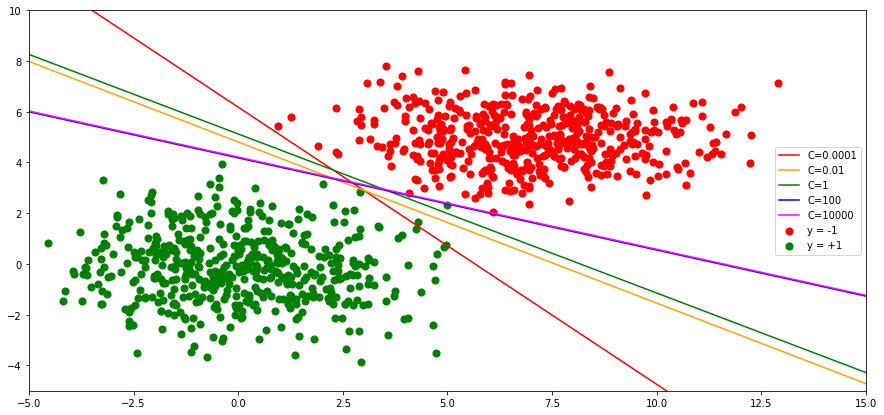

In [57]:
plt.scatter(data0[:, 0], data0[:, 1], c='red', s=50, label='y = -1')
plt.scatter(data1[:, 0], data1[:, 1], c='green', s=50, label='y = +1')
#plt.legend(['y = -1', 'y = 1'])
x_arr = np.linspace(-10, 15, 3000)
colors = ['red', 'orange', 'green', 'blue', 'magenta']

for i, C in enumerate([0.0001, 0.01,  1, 100, 10000]):
    SVM_classifier = SVC(C=C, kernel='linear')
    SVM_classifier.fit(data, y)
    w_1 = SVM_classifier.coef_[0][0]
    w_2 = SVM_classifier.coef_[0][1]
    w_0 = SVM_classifier.intercept_[0]
    plt.plot(x_arr, -(w_0 + w_1 * x_arr) / w_2, color=colors[i], label='C='+str(C))

axes = plt.gca()
axes.set_xlim([-5,15])
axes.set_ylim([-5,10])
plt.legend(loc=0)
plt.show()

Гиперпараметр $C$ отвечает за то, что является более приоритетным для классификатора, — "подгонка" под обучающую выборку или максимизация ширины разделяющей полосы.
 - При больших значениях $C$ классификатор сильно настраивается на обучение, тем самым сужая разделяющую полосу.
 - При маленьких значениях $C$ классификатор расширяет разделяющую полосу, при этом допуская ошибки на некоторых объектах обучающей выборки.